In [1]:
import math
import torch
import gpytorch
import numpy as np
from scipy.stats import norm
import csv
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pylab import *

from bo_functions import best_error_advanced
from bo_functions import calc_ei_advanced

from bo_plotters import plotter_adv
from bo_plotters import y_plotter_adv
from bo_plotters import stdev_plotter_adv
from bo_plotters import ei_plotter_adv

In [2]:
reader = csv.reader(open("LHS_Toy_3_Input.csv"), delimiter=",") #Reads CSV containing 3 x 25 LHS design
lhs_design = list(reader) #Creates list from CSV
all_p = np.array(lhs_design).astype("float") #Turns LHS design into a useable python array (3 x 25)

In [3]:
#Set noise parameters and true value of Theta to generate training data
noise_mean = 0
noise_std = 0.1**2

#Creates noise values with a certain stdev and mean from a normal distribution
noise = np.random.normal(size=1,loc = noise_mean, scale = noise_std) #Number

# True function is y=T1*x + T2*x^2 + x^3 with Gaussian noise, not used in this model
# Theta_True = np.array([1,-1]) #1x2
# def y_true_func(p_x):
#     y_true = Theta_True[0]*p_x + Theta_True[1]*p_x**2 +p_x**3 + noise #1x25
#     return y_true

#Creates an array for train_y that will be filled with the for loop
all_y = np.zeros(len(all_p)) #1 x 100

#Iterates over evey combination of theta to find the SSE for each combination
for i in range(len(all_p)):
    theta_1 = all_p[i,0] #25x1 
    theta_2 = all_p[i,1] #25x1
    x = all_p[i,2] #25x1
    y_exp = theta_1*x + theta_2*x**2 +x**3 + noise #A Number
    all_y[i] = y_exp #A number

#Separate training and testing data
separation_factor = 0.8 #80% will be training data
train_split = int(np.round(len(all_y))*separation_factor)-1 #Creates the index on which to split data

train_y =torch.tensor(all_y[:train_split]) #1x19
test_y = torch.tensor(all_y[train_split:]) #1x6
train_p = torch.tensor(all_p[:train_split,:]) #1x19
test_p = torch.tensor(all_p[train_split:,:]) #1x6

In [4]:
# We will use the simplest form of GP model, exact inference
#This class is the Exact GP model and we are defining the class as ExactGPModel
class ExactGPModel(gpytorch.models.ExactGP): #Exact GP does not add noise
    """
    The base class for any Gaussian process latent function to be used in conjunction
    with exact inference.

    Parameters
    ----------
    torch.Tensor train_inputs: (size n x d) The training features :math:`\mathbf X`.
    
    torch.Tensor train_targets: (size n) The training targets :math:`\mathbf y`.
    
    ~gpytorch.likelihoods.GaussianLikelihood likelihood: The Gaussian likelihood that defines
        the observational distribution. Since we're using exact inference, the likelihood must be Gaussian.
    
    Methods
    -------
    The :meth:`__init__` function takes training data and a likelihood and computes the objects of mean and covariance 
    for the forward method

    The :meth:`forward` function should describe how to compute the prior latent distribution
    on a given input. Typically, this will involve a mean and kernel function.
    The result must be a :obj:`~gpytorch.distributions.MultivariateNormal`.
    
    Returns
    -------
    Calling this model will return the posterior of the latent Gaussian process when conditioned
    on the training data. The output will be a :obj:`~gpytorch.distributions.MultivariateNormal`.
    """

    def __init__(self, train_p, train_y, likelihood):
        """
        Initializes the model
        
        Parameters
        ----------
        self : A class,The model itself. In this case, gpytorch.models.ExactGP
        train_T : tensor, The inputs of the training data
        train_y : tensor, the output of the training data
        likelihood : bound method, the lieklihood of the model. In this case, it must be Gaussian
        
        """
        #Initializes the GP model with train_Y, train_y, and the likelihood
        ##Calls the __init__ method of parent class
        super(ExactGPModel, self).__init__(train_p, train_y, likelihood)
        #Defines a constant prior mean on the GP. Used in the forward method
        self.mean_module = gpytorch.means.ConstantMean()
        #Defines prior covariance matrix of GP to a scaled RFB Kernel. Used in the forward method
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()) 

    def forward(self, x):
        """
        A forward method that takes in some (n×d) data, x, and returns a MultivariateNormal with the prior mean and 
        covariance evaluated at x. In other words, we return the vector μ(x) and the n×n matrix Kxx representing the 
        prior mean and covariance matrix of the GP.
        
        Parameters
        ----------
        self : A class,The model itself. In this case, gpytorch.models.ExactGP
        x : tensor, first input when class is called
        
        Returns:
        Vector μ(x)
        
        """
        #Defines the mean of the GP based off of x
        mean_x = self.mean_module(x) #1x19
        #Defines the covariance matrix based off of x
        covar_x = self.covar_module(x) #19 x 19 covariance matrix
        #Constructs a multivariate normal random variable, based on mean and covariance. 
            #Can be multivariate, or a batch of multivariate normals
            #Returns multivariate normal distibution gives the mean and covariance of the GP        
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x) #Multivariate dist based on 1x19^2 tensor

# initialize likelihood and model
##Assumes a homoskedastic noise model p(y | f) = f + noise
likelihood = gpytorch.likelihoods.GaussianLikelihood()

#Defines our model in terms of the class parameters above
model = ExactGPModel(train_p, train_y, likelihood)

In [5]:
# Find optimal model hyperparameters
training_iter = 300

#Puts the model in training mode
model.train()

#Puts the likelihood in training mode
likelihood.train()

# Use the adam optimizer
    #algorithm for first-order gradient-based optimization of stochastic objective functions
    # The method is also appropriate for non-stationary objectives and problems with very noisy and/or sparse gradients. 
    #The hyper-parameters have intuitive interpretations and typically require little tuning.
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  #Needs GaussianLikelihood parameters, and a learning rate
    #lr default is 0.001

# Calculate"Loss" for GPs

#The marginal log likelihood (the evidence: quantifies joint probability of the data under the prior)
#returns an exact MLL for an exact Gaussian process with Gaussian likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model) #Takes a Gaussian likelihood and a model, a bound Method
#iterates a give number of times
for i in range(training_iter): #0-299
    # Zero gradients from previous iteration - Prevents past gradients from influencing the next iteration
    optimizer.zero_grad() 
    # Output from model
    output = model(train_p) # A multivariate norm of a 1 x 19^2 tensor
    # Calc loss and backprop gradients
    #Minimizing -logMLL lets us fit hyperparameters
    loss = -mll(output, train_y) #A number (tensor)
    #computes dloss/dx for every parameter x which has requires_grad=True. 
    #These are accumulated into x.grad for every parameter x
    loss.backward()
#     print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
#         i + 1, training_iter, loss.item(),
#         model.covar_module.base_kernel.lengthscale.item(),
#          model.likelihood.noise.item()
#     ))
    #optimizer.step updates the value of x using the gradient x.grad. For example, the SGD optimizer performs:
    #x += -lr * x.grad
    optimizer.step()

In [6]:
# Get into evaluation (predictive posterior) mode
#Puts model in evaluation mode
model.eval()
#Puts likelihood in evaluation mode
likelihood.eval()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [7]:
#Code for EI

with gpytorch.settings.fast_pred_var(), torch.no_grad():
#torch.no_grad() 
    #Disabling gradient calculation is useful for inference, 
    #when you are sure that you will not call Tensor.backward(). It will reduce memory consumption
    #Note: Can't use np operations on tensors where requires_grad = True
#gpytorch.settings.fast_pred_var() 
    #Use this for improved performance when computing predictive variances. 
    #Good up to 10,000 data points
#Predicts data points for model (sse) by sending the model through the likelihood
    observed_pred = likelihood(model(test_p)) #1 x 6
    
#Calculates model mean  
model_mean = observed_pred.mean #1x6
#Calculates the variance of each data point
model_variance = observed_pred.variance #1x6
#Calculates the standard deviation of each data point
model_stdev = np.sqrt(observed_pred.variance)
y_model = observed_pred.loc #1 x 6

#Separates parameters for use
test_p_1 = test_p[:,0].numpy() #Theta1 #1 x 6
test_p_2 = test_p[:,1].numpy() #Theta 2 #1 x 6
test_p_3 = test_p[:,2].numpy() #x #1 x 6

#Calculates expected y for each parameter space parameter
y_exp = test_p_1*test_p_3 + test_p_2*test_p_3**2 +test_p_3**3 + noise #1 x6

<class 'numpy.ndarray'>


In [8]:
#Calculates best_error and expected improvement
best_error = best_error_advanced(y_model, y_exp)[0] #A number
best_x = best_error_advanced(y_model, y_exp)[1] #1x3
ei = calc_ei_advanced(best_error,model_mean,model_variance, y_exp) #1x6
print(ei)

[0.28917559 0.28202475 0.29015737 0.30406563 0.20769073 0.15785833]


In [9]:
#Test calc_ei_adv (to compare with hand calcs)
f_best = 1
mu = torch.tensor([3])
y_exp = np.array([4])
pred_var = torch.tensor([1])
print(calc_ei_advanced(f_best,mu,pred_var,y_exp))

[-0.45583089]


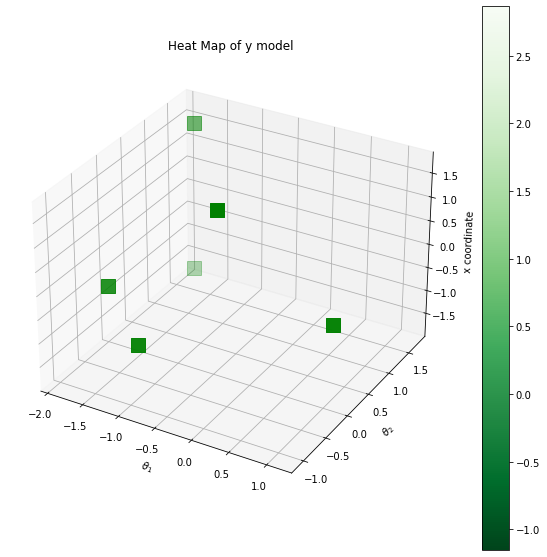

None


In [10]:
title2 = "y model"
print(y_plotter_adv(test_p, y_model, title2))

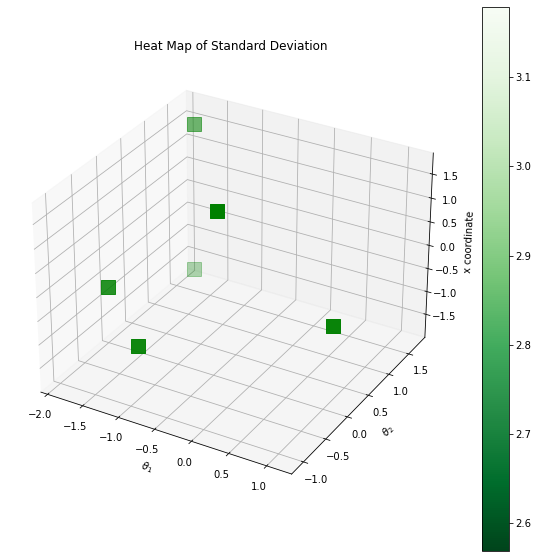

None


In [11]:
print(stdev_plotter_adv(test_p, model_stdev))

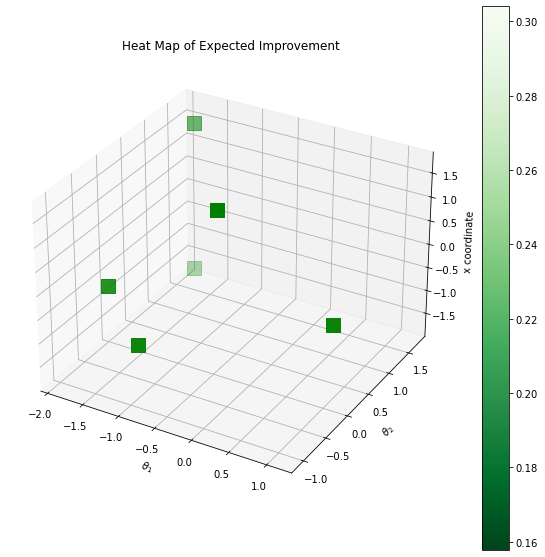

None


In [12]:
print(ei_plotter_adv(test_p, ei))